#              Lending Club Loans and Economic Metrics Processing Script


1. This script will fetch Lending Club loans for the year 2015, collected from https://www.lendingclub.com/info/download-data.action and economic metrics for the year 2017, collected from American Fact Finder at https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t for individual zip code of United States of America

2. This script will clean Lending Club loan data and create the target variable to calculate return

3. This script will clean Economic metric data and create population weight for each 3-digit zip code

4. This script will create population weighted economic metrics and merge them with Lending Club loan data

5. This script will create new features such as cr_hist, new_dti, top1 10 states by Charged_Off loans & change_in_fico

5. This script will create re-sample data based on Random Under Sampling, Random Over Sampling and SMOTE after PCA

### Libraries

In [2]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
import warnings
warnings.filterwarnings("ignore")

### Definitions

##### 1. Defining directory to read

In [12]:
def is_integer(x):
    try:
        return (int(x) == float(x))
    except:
        return False

# Define the directories that contain the files downloaded 
dir_2015 = "/".join( ["D:"]+["LendingClubData2016"] )

##### 2. Defining read and skip unwanted rows

In [4]:
def ingest_files(directory):
    
    # Adding Slash if not available
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)
        
        # Some of the files have "summary" lines are invalid and needs to be removed
        invalid_rows = (output[i].id.apply( lambda x : is_integer(x) == False ))
        if invalid_rows.sum() > 0:
            print("        Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows == False]
    
    return output

##### 3. Defining return target variable

In [5]:
def ret_method_3(T, i):
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data['loan_length']
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, final_data.loan_length)) / ( 1 - (1 + i) )
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)
    return( (12/T) * ( ( final_return - final_data['funded_amnt'] ) / final_data['funded_amnt'] ) )


##### 4. Defining Population weight

In [6]:
def create_eco_file(df_t):
    
    #making zip code as 5 digit code
    df_t['Id2']=df_t['Id2'].apply(lambda x:format(x,'05d'))

    #striping last two digits
    df_t['Id2'] = df_t['Id2'].astype('str').str[0:3]

    #creating sum of population for each 3 digit zipcode
    df_sum=pd.DataFrame(df_t.groupby('Id2',as_index=False)['Estimate; EMPLOYMENT STATUS - Population 16 years and over'].sum().reset_index())
   
    #Renaming for calculation
    df_sum=df_sum.rename(columns={'Estimate; EMPLOYMENT STATUS - Population 16 years and over':'Total_Pop'})
    df_t=df_t.rename(columns={'Estimate; EMPLOYMENT STATUS - Population 16 years and over':'Zip_Pop'})
    
    df_merge=pd.merge(df_t,df_sum,left_on=['Id2'],
                 right_on=['Id2'],how='left')
    
    #calculating population weight and aggregating at each 3 digit zipcode to validate
    df_merge['Pop_wt']=df_merge['Zip_Pop']/df_merge['Total_Pop']
    
    df_merge['zip_code']=df_merge['Id2'].astype('int').apply(lambda x:format(x,'03d'))
    
    #Imputing missing values with median values
    for col in list_eco:
        if col == 'Estimate; EMPLOYMENT STATUS - Population 16 years and over':
            df_merge['Zip_Pop'].fillna(df_merge['Zip_Pop'].median(),inplace=True)
        else:
            df_merge[col].fillna(df_merge[col].median(),inplace=True)
    
    #Removing NA's if there are still any
    df_merge=df_merge.dropna(axis=0)
    
    print('Total unique zip codes are-->',df_merge['zip_code'].nunique())
    
    # calculating population weighted values
    for col in list_eco:
        if col == 'Estimate; EMPLOYMENT STATUS - Population 16 years and over':
            continue
        else:
            df_merge[col]=df_merge[col].astype('float')
            df_merge[col]=df_merge[col]*df_merge['Pop_wt']
    
    #Creating the final aggregated dataset, grouped by first three digit zipcodes
    df_final=df_merge.groupby('zip_code').sum().reset_index()
    
    print("Cleaning process for economic metrics is completed ")
    
    return df_final

##### 5. Cleaning Percentage and Date variables

In [7]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

##### 6. Cleaning economic metrics file

In [8]:
def clean_eco_file(df):
    df.replace("-",np.nan,inplace=True)
    df.replace('N',np.nan,inplace=True)
    df.replace(to_replace="250,000+",value="250000",inplace=True )
    df.replace(to_replace="2,500-",value="2500",inplace=True )
    df.astype('float').fillna(0,inplace=True)
    print("Special characters are removed from the file")
    return df

##### 7. Cleaning loan statistics file

In [9]:
def clean_df(df):

    df['verification_status'].iloc[np.where(df['verification_status']=='Source Verified')]='Verified'
    df['term'].iloc[np.where(df['term']==' 36 months')]='36months'
    df['term'].iloc[np.where(df['term']==' 60 months')]='60months'
    df['home_ownership'].iloc[np.where(df['home_ownership']=='ANY')]='MORTGAGE'
    for val in value:
        df['purpose'][df['purpose']== val]='other'
        
    dict={
    '< 1 year':1,
    '1 year': 2,
    '2 years':3,
    '3 years':4,
    '4 years':5,
    '5 years':6,
    '6 years':7,
    '7 years':8,
    '8 years':9,
    '9 years':10,
    '10+ years':11
    }
    df['emp_length']=df['emp_length'].map(dict)
    df['emp_length']=df['emp_length'].astype('category',ordered=True)
    
    #creating categories and floats
    for col in cat_cols:
        if col=='emp_length':
            df[col]=df[col].astype('category',ordered=True)
        else:
            df[col]=df[col].astype('category',ordered=False)

    #Dropping nulls
    df.dropna(axis=0,inplace=True)
    
    df_dum= pd.DataFrame(pd.get_dummies(df, columns=category, prefix_sep = "::", drop_first = True))
    return df_dum

##### 6. Defining feature engineering and merging

In [10]:
def feature_eng(final_data):
    final_data["outcome"] = final_data.loan_status.isin(["Charged Off", "Default"])
    print('outcome is created')
    final_data['cr_hist'] = (final_data.issue_d - final_data.earliest_cr_line) / np.timedelta64(1, 'M')
    continuous_features.append('cr_hist')
    print('credit history is created')
    final_data['NMRA']=final_data['dti']*(final_data['annual_inc']/12)+ final_data['installment']
    final_data['New_dti']=final_data['NMRA']/(final_data['annual_inc']/12)
    final_data.drop('NMRA',axis=1,inplace=True)
    print('New DTI is created')
    cols=['revol_bal']
    for col in cols:
        final_data[str(col)+"_wrt_loanamnt"]=final_data[col]/final_data['funded_amnt']
    list_st=['CA','NY','TX','FL','IL','NJ','PA','GA','OH','VA']      
    for st in list_st:
        final_data['state_'+st]=final_data['addr_state'].apply(lambda x: 1 if x == st else 0)
    state_cols=['state_CA','state_NY','state_TX','state_FL','state_IL','state_NJ','state_PA','state_GA','state_OH','state_VA']
    for st in state_cols:
        final_data[st]=final_data[st].astype('category',ordered=False)
    print('Top states are created is created')
    #change in fico
    final_data['change_in_fico'] = np.nan
    final_data['change_in_fico']  = final_data['fico_range_high']/final_data['fico_range_low']
    print('Change in Fico score is created')
    #making 3 digit zip_code
    final_data['zip_code']=final_data['zip_code'].str.strip('x').astype('int').apply(lambda x:format(x,'03d'))
    
    final_data = final_data.sort_values(by='zip_code')
    df_final.sort_values(by='zip_code',inplace=True)
    #final_data.to_csv('LendingClub_Target.csv',index=False)
    #df_eco_sel.to_csv('Socio_economic.csv',index=False)
    df_merge=pd.merge(final_data,df_final,on='zip_code',how = 'inner')
    print('Merging completed')
    
    print('All processess are completed')
    
    return df_merge

### Features 

In [11]:
# Identify the columns to use
cols_to_pick = ['id','loan_amnt','funded_amnt','term','int_rate',
                 'installment','grade','emp_length', 'home_ownership',
                 'annual_inc','verification_status','issue_d',
                 'loan_status','purpose','dti', 'delinq_2yrs',
                 'earliest_cr_line','open_acc','pub_rec', 'fico_range_high',
                 'fico_range_low', 'revol_bal','revol_util', 'total_pymnt',
                                                    'last_pymnt_d', 'recoveries','addr_state','zip_code']

# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
                     'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                                'fico_range_high', 'fico_range_low', 'total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']
geo_cols = ['addr_state','zip_code']

# All categorical columns other than "loan_status" will be used as discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

### Reading Files

In [14]:
files_2015 = ingest_files(dir_2015)

Directory D:/LendingClubData2016/ has 1 files:
    Reading file LoanStats_securev1_2016Q1.csv
        Found 2 invalid rows which were removed


In [15]:
data_2015 = pd.concat(files_2015.values()).reset_index(drop = True)
data_2015=data_2015.sort_values(by='id')

# Keep only the columns of interest
final_data = data_2015[cols_to_pick].copy()

print("Starting with " + str(len(final_data)) + " rows")

Starting with 133887 rows


In [16]:
for i in float_cols:
    final_data[i] = final_data[i].astype(float)
    
for i in perc_cols:
    final_data[i] = final_data[i].apply( clean_perc )

for i in date_cols:
    final_data[i] = final_data[i].apply( clean_date )
    
for i in cat_cols:
    final_data.loc[final_data[i].isnull(), i] = None

In [17]:
# Remove all rows for loans that were paid back on the days
# they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)
final_data = final_data[final_data.loan_length != 0]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 492 rows


### Visualizing Columns

In [18]:
def visualize_columns():
    ret_cols=['return']
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i], reverse=True)[:3]
        smallest_val = min(final_data[i])
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()
        
    # Categorical columns 
    for i in cat_cols:
        print(i)
        print(str(len(set(final_data[i]))) + " distinct values")
        print(final_data[i].value_counts())
        print("")
        print("")
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

In [19]:
final_data['return'] = ret_method_3(5*12, 0.0024) #3% 

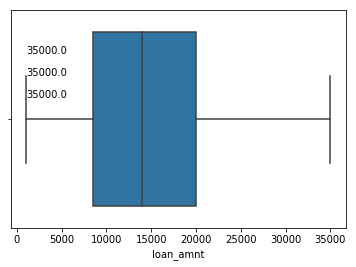

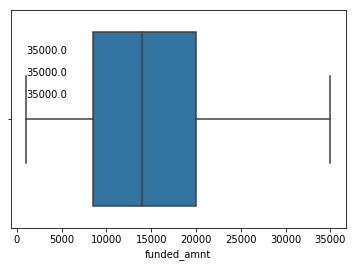

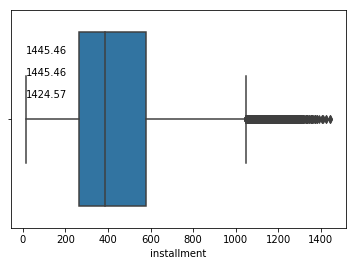

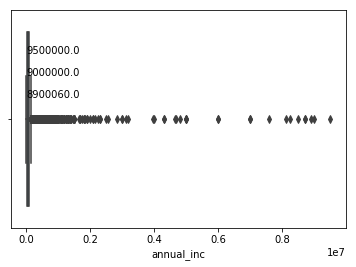

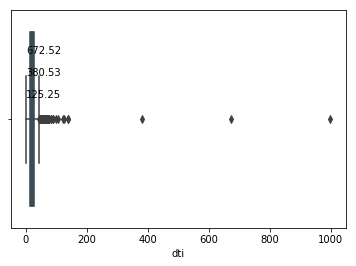

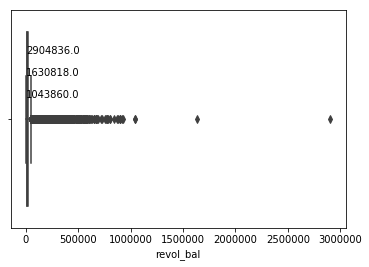

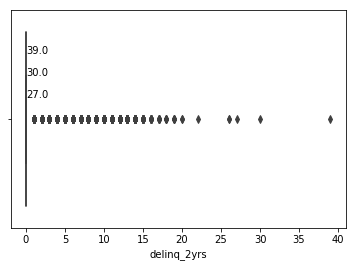

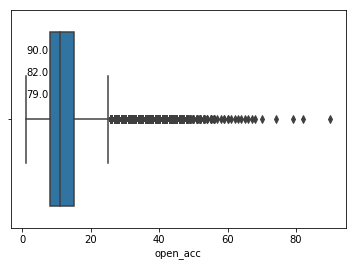

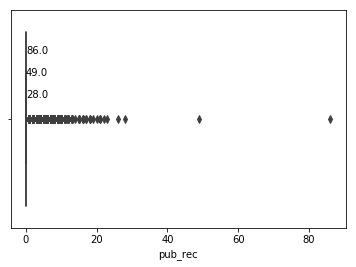

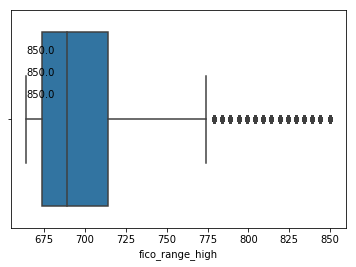

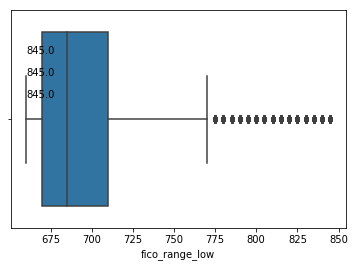

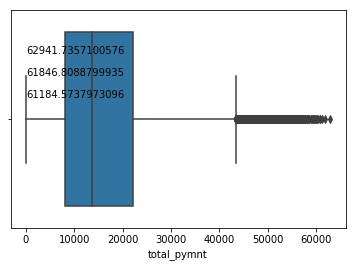

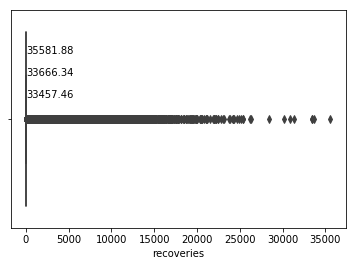

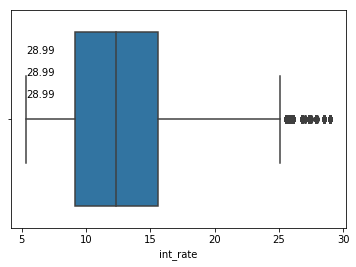

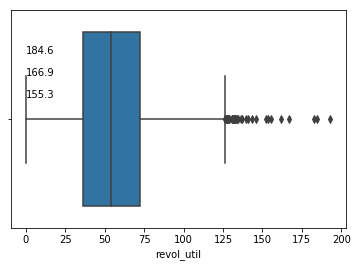

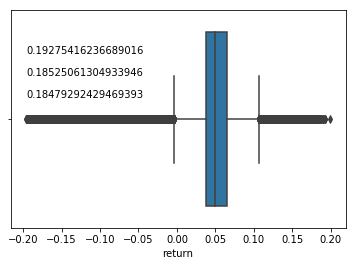

term
2 distinct values
 36 months    282477
 60 months    137525
Name: term, dtype: int64


grade
7 distinct values
C    120250
B    117346
A     73219
D     62458
E     34824
F      9761
G      2144
Name: grade, dtype: int64


emp_length
12 distinct values
10+ years    141174
2 years       37408
< 1 year      34246
3 years       33328
1 year        27407
5 years       24870
4 years       24447
8 years       21494
7 years       18366
6 years       16799
9 years       16716
Name: emp_length, dtype: int64


home_ownership
4 distinct values
MORTGAGE    207178
RENT        167217
OWN          45605
ANY              2
Name: home_ownership, dtype: int64


verification_status
3 distinct values
Source Verified    184259
Verified           122695
Not Verified       113048
Name: verification_status, dtype: int64


loan_status
7 distinct values
Fully Paid            303530
Charged Off            77093
Current                37303
Late (31-120 days)      1132
In Grace Period          606
Late (16-3

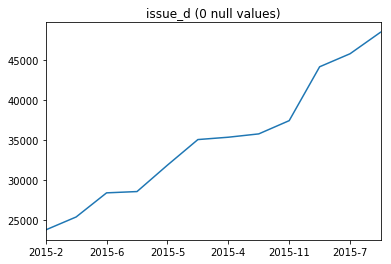

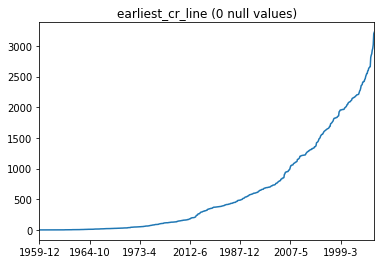

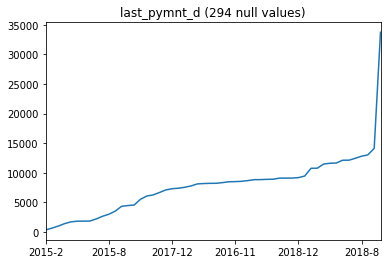

In [28]:
visualize_columns()

### Cleaning

##### 1. Removing outliers

In [20]:
n_rows = len(final_data)
final_data = final_data[final_data.annual_inc < 9000000]
final_data = final_data[final_data.revol_util < 170]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 73 rows


##### 2. Removing non Charged Off, Fully Paid or Default Loans

In [21]:
n_rows = len(final_data)
final_data = final_data[final_data.loan_status.isin(['Fully Paid','Charged Off','Default'])]
print("Removed " + str(n_rows - len(final_data)) + " rows")
print("Remaining",final_data.shape[0]," rows")

Removed 13897 rows
Remaining 119425  rows


##### 3. Removing null values

In [22]:
required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")
n_rows = len(final_data)
final_data.dropna(subset = required_cols ,inplace=True)
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 164 rows


##### 4. Percentage of Loans by Grade

In [23]:
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()
default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret = final_data.groupby("grade").apply(lambda x : np.mean(x['return']*100 ))
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate))
combined = pd.DataFrame(perc_by_grade)
combined['default'] = default_by_grade
combined['int_rate'] = int_rate_by_grade
combined['return'] = ret
combined

,grade,default,int_rate,return
A,21.369098,5.654306,6.655307,3.722785
B,30.704086,13.307663,9.967616,3.767658
C,26.597966,23.429274,13.449915,3.245959
D,11.760760,32.938828,17.593977,2.655276
E,6.527700,42.723186,20.736270,1.484785
F,2.417387,51.612903,24.316566,0.314104
G,0.623003,54.912517,28.000686,-0.389301


##### 5. Removing leakage variables

In [24]:
continuous_features = [i for i in continuous_features if i not in ["total_pymnt", "recoveries"]]

In [25]:
final_data.shape

(119261, 30)

### SOCIO-ECONOMIC DATA

In [140]:
os.chdir(r"D:\AmericanFactFinder")
df_eco=pd.read_csv('ACS_17_5YR_DP03_with_ann.csv',skiprows=1)

In [164]:
list_eco=['Id2',
'Estimate; EMPLOYMENT STATUS - Population 16 years and over',
'Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force',
'Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate',
'Estimate; COMMUTING TO WORK - Workers 16 years and over',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- drove alone',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- carpooled',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Public transportation (excluding taxicab)',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Walked',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Other means',
'Estimate; COMMUTING TO WORK - Workers 16 years and over - Worked at home',
'Estimate; COMMUTING TO WORK - Mean travel time to work (minutes)',
'Estimate; OCCUPATION - Civilian employed population 16 years and over',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Management, business, science, and arts occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Service occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Sales and office occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Natural resources, construction, and maintenance occupations',
'Estimate; OCCUPATION - Civilian employed population 16 years and over - Production, transportation, and material moving occupations',
'Estimate; INDUSTRY - Civilian employed population 16 years and over',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Agriculture, forestry, fishing and hunting, and mining',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Construction',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Manufacturing',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Wholesale trade',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Retail trade',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Transportation and warehousing, and utilities',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Information',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Finance and insurance, and real estate and rental and leasing',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Professional, scientific, and management, and administrative and waste management services',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Educational services, and health care and social assistance',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Arts, entertainment, and recreation, and accommodation and food services',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Other services, except public administration',
'Estimate; INDUSTRY - Civilian employed population 16 years and over - Public administration',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Private wage and salary workers',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Government workers',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Self-employed in own not incorporated business workers',
'Estimate; CLASS OF WORKER - Civilian employed population 16 years and over - Unpaid family workers',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - Less than $10,000',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $10,000 to $14,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $15,000 to $24,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $25,000 to $34,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $35,000 to $49,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $50,000 to $74,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $75,000 to $99,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $100,000 to $149,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $150,000 to $199,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Total households - $200,000 or more',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - Less than $10,000',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $10,000 to $14,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $15,000 to $24,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $25,000 to $34,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $35,000 to $49,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $50,000 to $74,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $75,000 to $99,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $100,000 to $149,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $150,000 to $199,999',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - $200,000 or more',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - Median family income (dollars)',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Families - Mean family income (dollars)',
'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Per capita income (dollars)',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With private health insurance',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With public coverage',
'Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - No health insurance coverage',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Married couple families',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Families with female householder, no husband present',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 18 to 64 years',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 65 years and over',
'Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - People in families']
df_eco_sel = df_eco[list_eco]

### Remove special characters

- N
- '-'
- +250,000
- -2,500

In [142]:
df_eco_clean=clean_eco_file(df_eco_sel)


Special characters are removed from the file


In [143]:
df_final = create_eco_file(df_eco_clean)

C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Total unique zip codes are--> 889
Cleaning process for economic metrics is completed 


In [144]:
df_final.head()

,zip_code,Id2,Zip_Pop,Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force,Percent; EMPLOYMENT STATUS - Civilian labor force - Unemployment Rate,Estimate; COMMUTING TO WORK - Workers 16 years and over,"Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- drove alone","Estimate; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- carpooled",Estimate; COMMUTING TO WORK - Workers 16 years and over - Public transportation (excluding taxicab),Estimate; COMMUTING TO WORK - Workers 16 years and over - Walked,...,Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - With health insurance coverage - With public coverage,Estimate; HEALTH INSURANCE COVERAGE - Civilian noninstitutionalized population - No health insurance coverage,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Married couple families,"Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - Families with female householder, no husband present",Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 18 to 64 years,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - All people - 18 years and over - 65 years and over,Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - People in families,index,Total_Pop,Pop_wt
0,006,6.0,927237,11157.142244,20.449049,8729.706927,7480.878945,643.651968,59.234554,290.551824,...,23119.531535,1874.835369,35.839950,65.386543,48.921741,45.726151,48.667460,0,40798428,1.0
1,007,7.0,1043146,13886.942587,17.805466,10890.846190,9192.100172,886.116438,116.472409,299.532506,...,23902.504924,2233.775617,31.747884,60.537449,44.357128,41.754325,45.056973,46,47984716,1.0
2,009,9.0,864037,20763.133500,14.377662,17451.718947,13858.656125,1713.325805,600.271596,399.608558,...,23529.369522,3551.488940,19.129695,48.859662,31.900361,31.983353,33.143598,82,35425517,1.0
3,010,10.0,399799,10894.655757,6.743137,9903.628038,7937.923864,669.111451,212.030173,478.464864,...,8231.062029,563.973269,3.773109,20.536321,14.513681,8.232406,8.138786,189,25187337,1.0
4,011,11.0,132130,8732.852577,10.666768,7695.162968,5686.427125,864.736426,360.340551,372.600500,...,11351.829055,886.767782,10.921894,37.255091,23.146734,14.909795,24.214696,52,1717690,1.0


### Feature Engineering & Merging

In [152]:
df_merge=feature_eng(final_data)

outcome is created
credit history is created
New DTI is created


C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """Entry point for launching an IPython kernel.


Top states are created is created
Change in Fico score is created
Merging completed
All processess are completed


In [154]:
df_merge.shape

(380074, 120)

### PCA

In [168]:
del_columns = ['id','grade','installment','int_rate','issue_d','earliest_cr_line','emp_length', 
               'return', 'return_lc', 'outcome','term', 'home_ownership','verification_status',
              'loan_status', 'purpose', 'total_pymnt', 'last_pymnt_d', 'recoveries', 'addr_state', 'zip_code',
       'loan_length','state_CA', 'state_NY', 'state_TX',
       'state_FL', 'state_IL', 'state_NJ', 'state_PA', 'state_GA', 'state_OH',
       'state_VA']

required = set(cols_to_pick) - set(del_columns)

to_be_added = ['emp_length', 
               'return', 'outcome','term', 'home_ownership','verification_status',
              'purpose','state_CA', 'state_NY', 'state_TX',
       'state_FL', 'state_IL', 'state_NJ', 'state_PA', 'state_GA', 'state_OH',
       'state_VA']

del_col_eco = ['Id2','Pop_wt']
list_eco[0]='Zip_Pop'
list_eco.remove('Estimate; EMPLOYMENT STATUS - Population 16 years and over')
required_eco = set(list_eco) - set(del_col_eco)

final_list_pca=list(list(required)+list(required_eco))

pca_data = df_merge[final_list_pca]

In [169]:
#to be added to PCA
df_add = df_merge[to_be_added]

In [170]:
#scaling pca data
from sklearn.preprocessing import scale
pca_scale= scale(pca_data)

C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


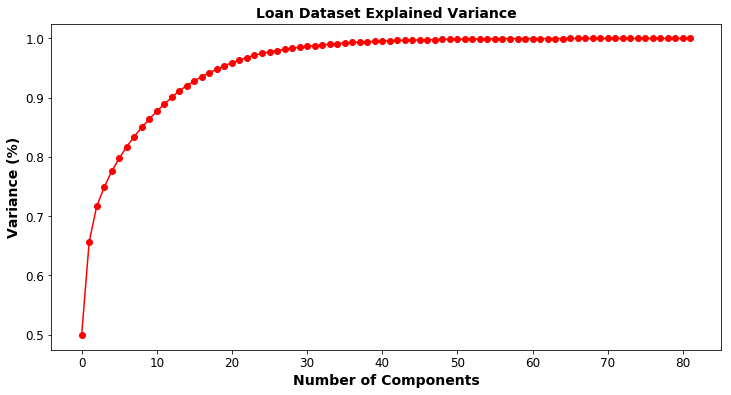

In [171]:
#visualizing PCA
from sklearn.decomposition import PCA
pca = PCA().fit(pca_scale)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize= (12,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), ls="-",color='red',marker='o')
plt.xlabel('Number of Components',size=14,fontweight='bold')
plt.ylabel('Variance (%)',size = 14,fontweight='bold') #for each component
plt.title('Loan Dataset Explained Variance',size=14,fontweight='bold')
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.show()

In [172]:
#selecting pca components with 90% variance
pca_1 = PCA(n_components = 15)
pca_dataset = pd.DataFrame(pca_1.fit_transform(pca_scale))

In [238]:
#merging with requuired columns
df_model = pd.merge(pca_dataset,df_add, left_index = True, right_index = True)

In [239]:
df_model.columns

Index([                    0,                     1,                     2,
                           3,                     4,                     5,
                           6,                     7,                     8,
                           9,                    10,                    11,
                          12,                    13,                    14,
                'emp_length',              'return',             'outcome',
                      'term',      'home_ownership', 'verification_status',
                   'purpose',            'state_CA',            'state_NY',
                  'state_TX',            'state_FL',            'state_IL',
                  'state_NJ',            'state_PA',            'state_GA',
                  'state_OH',            'state_VA'],
      dtype='object')

### Sampling

In [240]:
# original dataset:
value=['home_improvement','major_purchase','medical','car','small_business','moving','vacation','house']
cat_cols=['term','emp_length','home_ownership','verification_status','purpose','state_CA', 'state_NY',
       'state_TX', 'state_FL', 'state_IL', 'state_NJ', 'state_PA', 'state_GA',
       'state_OH', 'state_VA']
category =['term','emp_length','home_ownership','verification_status','purpose']

df_model_2=clean_df(df_model)

C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Thatoi\Downloads\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [241]:
os.chdir("D:/Regression_File")
df_model_2.columns=[str(col) + '_Reg' for col in df_model_2.columns]
df_model_2.sample(200000).to_csv('Regression.csv',index=False)

In [242]:
df_model_2.head()

,0_Reg,1_Reg,2_Reg,3_Reg,4_Reg,5_Reg,6_Reg,7_Reg,8_Reg,9_Reg,...,emp_length::10.0_Reg,emp_length::11.0_Reg,home_ownership::OWN_Reg,home_ownership::RENT_Reg,verification_status::Verified_Reg,purpose::debt_consolidation_Reg,purpose::educational_Reg,purpose::other_Reg,purpose::renewable_energy_Reg,purpose::wedding_Reg
0,1.589990,18.820769,5.985410,0.966909,3.254152,-0.326784,-4.224156,-1.784024,1.811055,2.047284,...,0,0,0,1,1,0,0,0,0,0
1,-6.076901,0.003453,0.726816,-2.523933,0.866890,0.265107,0.965223,-0.060390,-1.177862,1.381149,...,0,0,0,0,1,1,0,0,0,0
2,-6.053516,-0.077601,0.786155,-0.417814,0.453341,0.358642,0.909464,0.090660,-0.557537,1.080944,...,0,1,0,0,1,1,0,0,0,0
3,-6.048887,-0.114008,0.872888,0.205694,-0.165587,0.381118,0.834133,0.478326,0.277613,-0.207484,...,0,0,1,0,0,0,0,0,0,0
4,-6.068512,-0.042962,0.889557,0.881260,-3.469484,0.588407,0.738412,0.471325,0.160544,-0.097664,...,0,1,1,0,0,0,0,1,0,0


#### Random Under Sampling

In [179]:
Y = df_model_2['outcome']
X = df_model_2.drop(['outcome','return'],axis=1)
Z = df_model_2[['return']]

In [228]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, Y_rus = rus.fit_resample(X,Y)
print('Resampled dataset shape %s' % Counter(Y_rus))

Resampled dataset shape Counter({False: 71232, True: 71232})


In [229]:
#creating RUS dataframe
X_rus = pd.DataFrame(X_rus)
X_rus.columns=[str(col) + '_RUS' for col in X_rus.columns]
Y_rus = pd.DataFrame(Y_rus).rename(columns={0:'outcome'})
RUS_sample_1 = pd.merge(X_rus,Y_rus, left_index= True, right_index=True)
RUS_sample_1.head()

,0_RUS,1_RUS,2_RUS,3_RUS,4_RUS,5_RUS,6_RUS,7_RUS,8_RUS,9_RUS,...,35_RUS,36_RUS,37_RUS,38_RUS,39_RUS,40_RUS,41_RUS,42_RUS,43_RUS,outcome
0,11.2523,-3.57193,13.6633,1.43887,-4.63446,-2.91904,-0.468369,1.11703,-0.970823,0.828678,...,0,0,1,0,0,0,0,0,0,False
1,3.64517,2.09013,-1.42486,1.87058,-2.49019,0.237967,-0.394934,0.439032,-0.825864,-0.591105,...,0,1,0,0,1,0,0,0,0,False
2,7.82939,-1.86937,-0.290045,-0.702522,1.68774,-0.595411,-1.22283,1.57767,-1.73171,-1.17048,...,1,0,1,1,1,0,0,0,0,False
3,6.64119,-5.5287,-0.762155,0.946388,-1.30675,0.0432257,-0.216195,-1.31351,0.0884782,-0.306015,...,0,0,1,0,0,0,0,0,0,False
4,-1.58657,-5.22177,1.23166,-0.805377,1.2846,1.18814,0.629064,-0.472566,3.74762,-0.498738,...,0,1,0,1,1,0,0,0,0,False


#### Random Over Sampling

In [230]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, Y_ros = ros.fit_resample(X,Y)
print('Resampled dataset shape %s' % Counter(Y_ros))

Resampled dataset shape Counter({True: 286671, False: 286671})


In [231]:
#creating ROS dataframe
X_ros = pd.DataFrame(X_ros)
X_ros.columns=[str(col) + '_ROS' for col in X_ros.columns]
Y_ros = pd.DataFrame(Y_ros).rename(columns={0:'outcome'})
ROS_sample_1 = pd.merge(X_ros,Y_ros, left_index= True, right_index=True)
ROS_sample_1.head()

,0_ROS,1_ROS,2_ROS,3_ROS,4_ROS,5_ROS,6_ROS,7_ROS,8_ROS,9_ROS,...,35_ROS,36_ROS,37_ROS,38_ROS,39_ROS,40_ROS,41_ROS,42_ROS,43_ROS,outcome
0,1.58999,18.8208,5.98541,0.966909,3.25415,-0.326784,-4.22416,-1.78402,1.81106,2.04728,...,0,0,1,1,0,0,0,0,0,True
1,-6.0769,0.00345332,0.726816,-2.52393,0.86689,0.265107,0.965223,-0.0603904,-1.17786,1.38115,...,0,0,0,1,1,0,0,0,0,False
2,-6.05352,-0.077601,0.786155,-0.417814,0.453341,0.358642,0.909464,0.0906596,-0.557537,1.08094,...,1,0,0,1,1,0,0,0,0,True
3,-6.04889,-0.114008,0.872888,0.205694,-0.165587,0.381118,0.834133,0.478326,0.277613,-0.207484,...,0,1,0,0,0,0,0,0,0,False
4,-6.06851,-0.0429619,0.889557,0.88126,-3.46948,0.588407,0.738412,0.471325,0.160544,-0.0976643,...,1,1,0,0,0,0,1,0,0,False


#### SMOTE

In [204]:
from imblearn.over_sampling import SMOTENC
smote = SMOTENC(categorical_features=[15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
                                      ,31,32,33,34,35,36,37,38,39,40,41,42,43])
X_sm, Y_sm = smote.fit_sample(X, Y)
print('Resampled dataset shape %s' % Counter(Y_sm))

Resampled dataset shape Counter({True: 286671, False: 286671})


In [214]:
#creating RUS dataframe
X_sm = pd.DataFrame(X_sm)
X_sm.columns=[str(col) + '_SMOTE' for col in X_sm.columns]
Y_sm = pd.DataFrame(Y_sm).rename(columns={0:'outcome'})
SMOTE_sample_1 = pd.merge(X_sm,Y_sm, left_index= True, right_index=True)
SMOTE_sample_1.tail()

,0_SMOTE,1_SMOTE,2_SMOTE,3_SMOTE,4_SMOTE,5_SMOTE,6_SMOTE,7_SMOTE,8_SMOTE,9_SMOTE,...,35_SMOTE,36_SMOTE,37_SMOTE,38_SMOTE,39_SMOTE,40_SMOTE,41_SMOTE,42_SMOTE,43_SMOTE,outcome
573337,0.167283,5.37258,-0.149203,-1.70077,0.593971,0.741772,-0.479808,2.94717,0.550687,0.357476,...,0,0,0,1,1,0,0,0,0,True
573338,7.75737,-0.360237,-3.65418,1.89488,1.22543,-0.321428,0.710611,-2.28726,-0.835185,0.988052,...,0,0,0,1,1,0,0,0,0,True
573339,5.29178,-4.85145,-0.694402,0.48402,-0.179639,-1.36858,-0.522487,-0.487077,1.01074,0.724732,...,0,0,1,1,1,0,0,0,0,True
573340,-5.891,2.00384,-0.191271,-1.38537,0.987008,-0.521374,0.560036,1.04931,0.232487,-0.347247,...,0,0,1,1,1,0,0,0,0,True
573341,-7.34592,2.22611,0.57366,1.0652,0.68193,0.256684,0.365331,0.0949418,-0.352581,0.662071,...,1,0,0,1,1,0,0,0,0,True


In [221]:
print(SMOTE_sample_1.shape)
print(RUS_sample_1.shape)
print(ROS_sample_1.shape)

(573342, 45)
(142464, 45)
(573342, 45)


#### Writing Sample dataset

In [232]:
os.chdir(r"D:\Sampling_Datasets")
RUS_sample_1.to_csv('RUS_Sample.csv',index=False)
ROS_sample_1.to_csv('ROS_Sample.csv',index=False)
SMOTE_sample_1.to_csv('SMOTE_Sample.csv',index=False)